# 영화리뷰 텍스트 감성분석 하기

### 버전확인 및 데이터 불러오기

In [149]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [150]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터 불러오기 함수 정의 및 데이터셋 분리 1

In [151]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

### 단어와 인덱스 간의 전환과 인코딩/디코딩 함수 정의

In [152]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 

word_to_index["<PAD>"]=0
word_to_index["<BOS>"]=1
word_to_index["<UNK>"]=2
word_to_index["<UNUSED>"]=3

index_to_word={}
index_to_word = {index:word for word, index in word_to_index.items()}

index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'# 사전에 없는(Unknown) 단어
index_to_word[3]='<UNUSED>'

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [153]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [154]:
import tensorflow as tf

x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


## RNN(LSTM) Model

In [155]:
vocab_size = 1000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 15  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 15)          15000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 768       
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 15,849
Trainable params: 15,849
Non-trainable params: 0
_________________________________________________________________


### 데이터셋 분리 2

In [156]:

x_val = x_train[:36000]   
y_val = y_train[:36000]

partial_x_train = x_train[110182:]  
partial_y_train = y_train[110182:]

print(x_val.shape)
print(partial_x_train.shape)

(36000, 41)
(36000, 41)


In [157]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
71/71 [==============================] - 2s 13ms/step - loss: 0.6634 - accuracy: 0.6762 - val_loss: 0.5738 - val_accuracy: 0.7642
Epoch 2/20
71/71 [==============================] - 1s 8ms/step - loss: 0.4908 - accuracy: 0.7820 - val_loss: 0.4412 - val_accuracy: 0.8025
Epoch 3/20
71/71 [==============================] - 1s 7ms/step - loss: 0.4246 - accuracy: 0.8100 - val_loss: 0.4196 - val_accuracy: 0.8086
Epoch 4/20
71/71 [==============================] - 1s 8ms/step - loss: 0.4071 - accuracy: 0.8184 - val_loss: 0.4213 - val_accuracy: 0.8073
Epoch 5/20
71/71 [==============================] - 1s 8ms/step - loss: 0.3983 - accuracy: 0.8215 - val_loss: 0.4068 - val_accuracy: 0.8131
Epoch 6/20
71/71 [==============================] - 1s 8ms/step - loss: 0.3939 - accuracy: 0.8227 - val_loss: 0.4057 - val_accuracy: 0.8139
Epoch 7/20
71/71 [==============================] - 1s 7ms/step - loss: 0.3918 - accuracy: 0.8237 - val_loss: 0.4045 - val_accuracy: 0.8144
Epoch 8/20
71/71 [=

In [158]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


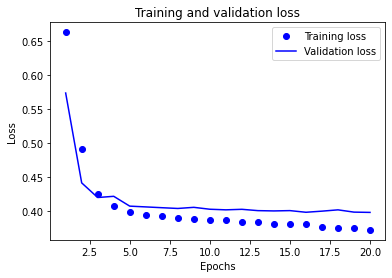

In [159]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

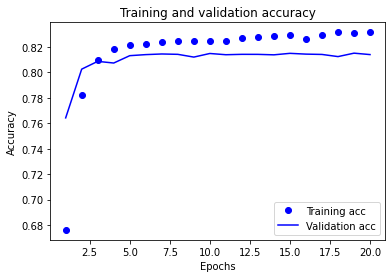

In [160]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 1D-CNN Model

In [161]:
vocab_size = 1000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 15   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 15)          15000     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 16)          1696      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_33 (Dense)             (None, 1)               

In [162]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
71/71 [==============================] - 1s 8ms/step - loss: 0.6759 - accuracy: 0.5928 - val_loss: 0.6078 - val_accuracy: 0.7374
Epoch 2/20
71/71 [==============================] - 0s 6ms/step - loss: 0.4827 - accuracy: 0.7867 - val_loss: 0.4145 - val_accuracy: 0.8072
Epoch 3/20
71/71 [==============================] - 0s 6ms/step - loss: 0.4022 - accuracy: 0.8138 - val_loss: 0.4025 - val_accuracy: 0.8121
Epoch 4/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3853 - accuracy: 0.8250 - val_loss: 0.3987 - val_accuracy: 0.8133
Epoch 5/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3751 - accuracy: 0.8294 - val_loss: 0.4006 - val_accuracy: 0.8145
Epoch 6/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3652 - accuracy: 0.8357 - val_loss: 0.3993 - val_accuracy: 0.8129
Epoch 7/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3543 - accuracy: 0.8419 - val_loss: 0.3949 - val_accuracy: 0.8169
Epoch 8/20
71/71 [==

In [163]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


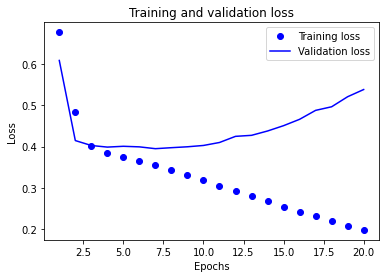

In [164]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

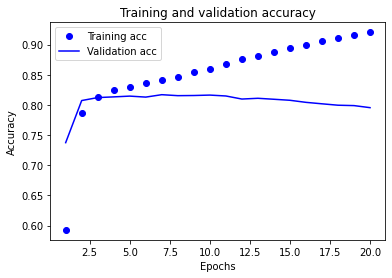

In [165]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## GlobalMaxPooling1D() Layer Only Model

In [166]:
vocab_size = 1000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 15   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 15)          15000     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 15)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 128       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 9         
Total params: 15,137
Trainable params: 15,137
Non-trainable params: 0
_________________________________________________________________


In [167]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
71/71 [==============================] - 1s 6ms/step - loss: 0.6827 - accuracy: 0.5904 - val_loss: 0.6644 - val_accuracy: 0.7161
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 0.6267 - accuracy: 0.7377 - val_loss: 0.5796 - val_accuracy: 0.7573
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.5365 - accuracy: 0.7721 - val_loss: 0.4990 - val_accuracy: 0.7814
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 0.4708 - accuracy: 0.7918 - val_loss: 0.4527 - val_accuracy: 0.7947
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.4328 - accuracy: 0.8060 - val_loss: 0.4293 - val_accuracy: 0.8013
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 0.4115 - accuracy: 0.8131 - val_loss: 0.4185 - val_accuracy: 0.8040
Epoch 7/20
71/71 [==============================] - 0s 5ms/step - loss: 0.3992 - accuracy: 0.8177 - val_loss: 0.4127 - val_accuracy: 0.8061
Epoch 8/20
71/71 [==

In [168]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


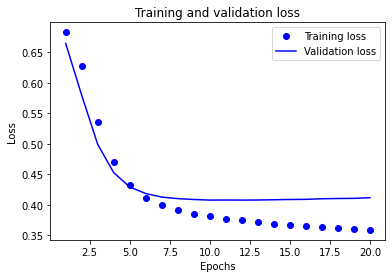

In [169]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

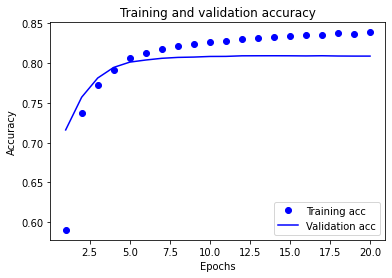

In [170]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 모델 결과 비교 표

| Model | loss | accuracy | val_loss | val_accuracy |
|:---|:---:|:---:|:---:|:---:|
| RNN(LSTM) | 0.3718 | 0.8314 | **0.3976** | **0.8140** |
| 1D-CNN | **0.1988** | **0.9204** | 0.5376 | 0.7954 |
|GlobalMaxPooling 1D()Layer Only | 0.3589 | 0.8389 | 0.4118 | 0.8089 |

In [171]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(1000, 15)


## 영어 임베딩

In [172]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
     f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [173]:
from gensim.test.utils import lee_corpus_list
from gensim.models import Word2Vec
model = Word2Vec(lee_corpus_list, vector_size=15, epochs=71)
word_vectors = model.wv

In [174]:
from gensim.models import KeyedVectors
word_vectors.save('vectors.kv')
reloaded_word_vectors = KeyedVectors.load('vectors.kv')

In [206]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data
# Check the "most similar words", using the default "cosine similarity" measure.
result = word_vectors.most_similar(positive=['woman','king'], negative=['man'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

queen: 0.7699


## 한국어 임베딩

In [181]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = KeyedVectors.load(word2vec_path)
vector = word_vectors.wv['끝']

import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model.save(temporary_filepath)   

In [204]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_path)

from numpy import dot
from numpy.linalg import norm
import numpy as np

vector_1 = word_vectors.wv['사랑']
vector_2 = word_vectors.wv['행복']
vector_3 = word_vectors.wv['끝']

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))
  
print('{}과 {}의 코사인 유사도 : {}'.format('사랑','행복',cos_sim(vector_1,vector_2)))
print('{}과 {}의 코사인 유사도 : {}'.format('사랑','끝',cos_sim(vector_1,vector_3)))

사랑과 행복의 코사인 유사도 : 0.7550067901611328
사랑과 끝의 코사인 유사도 : 0.1875794529914856
